https://www.youtube.com/watch?v=woKYyhLCcnU

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy as db
from sqlalchemy.orm import Session
import matplotlib as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

%matplotlib inline

#### Creating sqlite database
    follow directions from [here](http://stat-computing.org/dataexpo/2009/sqlite.html) for sqlite database setup

In [2]:
engine = db.create_engine('sqlite:///flights.sqlite3', echo=True)     #relative directory (in same folder as this notebook so no directory)
connection = engine.connect()
flights = db.Table('ontime', db.MetaData(), autoload=True, autoload_with=engine)
session = Session(bind=engine)


2019-12-02 19:52:12,363 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-02 19:52:12,364 INFO sqlalchemy.engine.base.Engine ()
2019-12-02 19:52:12,365 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-02 19:52:12,366 INFO sqlalchemy.engine.base.Engine ()
2019-12-02 19:52:12,369 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("ontime")
2019-12-02 19:52:12,370 INFO sqlalchemy.engine.base.Engine ()
2019-12-02 19:52:12,373 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ontime' AND type = 'table'
2019-12-02 19:52:12,374 INFO sqlalchemy.engine.base.Engine ()
2019-12-02 19:52:12,375 INFO sqlalchemy.engine.base.Engine PRAGMA main.foreign_key_list("ontime")
2019-12-02 19:52:12,376 INFO sqlalchemy.engine.base.Engine ()
2019-12-02 19:52:12,377 INFO sqlalchemy.engine.base.Engine PRAGMA temp

In [3]:
cols = flights.columns.keys()

In [4]:
#q = session.query(flights)
#q2 = q.filter(flights.columns.Year.cast(db.Integer) == 2008)
#%%time
#list08 = q2.all()

In [5]:
%%time
first = list(session.query(flights).limit(7009728))
#7009728

2019-12-02 19:52:22,115 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2019-12-02 19:52:22,118 INFO sqlalchemy.engine.base.Engine SELECT ontime."Year" AS "ontime_Year", ontime."Month" AS "ontime_Month", ontime."DayofMonth" AS "ontime_DayofMonth", ontime."DayOfWeek" AS "ontime_DayOfWeek", ontime."DepTime" AS "ontime_DepTime", ontime."CRSDepTime" AS "ontime_CRSDepTime", ontime."ArrTime" AS "ontime_ArrTime", ontime."CRSArrTime" AS "ontime_CRSArrTime", ontime."UniqueCarrier" AS "ontime_UniqueCarrier", ontime."FlightNum" AS "ontime_FlightNum", ontime."TailNum" AS "ontime_TailNum", ontime."ActualElapsedTime" AS "ontime_ActualElapsedTime", ontime."CRSElapsedTime" AS "ontime_CRSElapsedTime", ontime."AirTime" AS "ontime_AirTime", ontime."ArrDelay" AS "ontime_ArrDelay", ontime."DepDelay" AS "ontime_DepDelay", ontime."Origin" AS "ontime_Origin", ontime."Dest" AS "ontime_Dest", ontime."Distance" AS "ontime_Distance", ontime."TaxiIn" AS "ontime_TaxiIn", ontime."TaxiOut" AS "ontime_TaxiOut", on

In [6]:
df = pd.DataFrame(data = first, columns = cols)

In [7]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,...,4,8,0,,0,NA,NA,NA,NA,NA
1,2008,1,3,4,754,735,1002,1000,WN,3231,...,5,10,0,,0,NA,NA,NA,NA,NA
2,2008,1,3,4,628,620,804,750,WN,448,...,3,17,0,,0,NA,NA,NA,NA,NA
3,2008,1,3,4,926,930,1054,1100,WN,1746,...,3,7,0,,0,NA,NA,NA,NA,NA
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,...,3,10,0,,0,2,0,0,0,32


# Flights in 2008

In [8]:
df08 = df[df.Year==2008]

In [9]:
len(df08)

7009728

In [10]:
df08 = df08.sample(frac = .20, random_state = 2)

In [11]:
len(df08)

1401946

### Preprocessing

In [12]:
#filter out Canceled flights
df08 = df08[df08.Cancelled != 1]

In [13]:
#need an arrival time for all the flights
df08 = df08[df08.ArrDelay != "NA"]

In [14]:
#drop 'CancellationCode','Diverted'
df08 = df08.drop(columns =['CancellationCode','Diverted', "Cancelled"])

In [15]:
#turning columns to ints
df08['ArrDelay'] = df08['ArrDelay'].astype(int)
df08['ArrTime'] = df08['ArrTime'].astype(int)
df08['AirTime'] = df08['AirTime'].astype(int)
df08['DepTime'] = df08['DepTime'].astype(int)
df08['ActualElapsedTime'] = df08['ActualElapsedTime'].astype(int)
df08['CRSElapsedTime'] = df08['CRSElapsedTime'].astype(int)
df08['DepDelay'] = df08['DepDelay'].astype(int)
df08['TaxiIn'] = df08['TaxiIn'].astype(int)
df08['TaxiOut'] = df08['TaxiOut'].astype(int)

In [16]:
#changing NAs to 0 for types of delays
df08.loc[df08.CarrierDelay =="NA", "CarrierDelay"]=0
df08.loc[df08.WeatherDelay =="NA", "WeatherDelay"]=0
df08.loc[df08.NASDelay=="NA","NASDelay"]=0
df08.loc[df08.SecurityDelay=="NA","SecurityDelay"]=0
df08.loc[df08.LateAircraftDelay =="NA","LateAircraftDelay"]=0

In [17]:
# Categorical boolean mask
categorical_feature_mask = df08.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08.columns[categorical_feature_mask].tolist()

In [18]:
7009728 - len(df08)

5638720

In [19]:
len(df08)

1371008

#### Preprocessing Categorical variables, one hot or engineering

###### TailNum

In [20]:
from collections import Counter
categorical_cols

['UniqueCarrier', 'TailNum', 'Origin', 'Dest']

In [21]:
#Drop or feature engineer too big to one hot
#encode as scalar
#https://en.wikipedia.org/wiki/Aircraft_registration
tailnums = Counter(df08['TailNum'])

In [22]:
tn = dict(tailnums)

In [23]:
len(tailnums)

5337

In [24]:
df08["TailNum"]

3163108    N510CA
4161727    N708AS
1603857    N359NW
565337     N73291
4612539    N991AT
            ...  
2412483    N208WN
1395880    N448SW
3680259    N371SW
475593     80409E
5871138    N4WBAA
Name: TailNum, Length: 1371008, dtype: object

In [25]:
for name, c in tn.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if "G" in name:
        print(name)

N3AGAA
N3DGAA
N700GS
N5EGAA
N701GS
N759GS
N667GB
N5FGAA
N739GB
N3BGAA
N709GB
N704PG
N501BG
N4XGAA
N5CGAA
N4YGAA
N3CGAA
N706RG
N5DGAA
N7AGAA
N7BGAA


Just going to drop. Seems like a pain to engineer anything out of it

In [26]:
df08 = df08.drop(columns="TailNum")

In [27]:
df08_onehot = df08

###### Origin

In [28]:
origins = Counter(df08['Origin'])

In [29]:
origins.most_common()

[('ATL', 81667),
 ('ORD', 67209),
 ('DFW', 54702),
 ('DEN', 47492),
 ('LAX', 42844),
 ('PHX', 39189),
 ('IAH', 35943),
 ('LAS', 34072),
 ('DTW', 31599),
 ('SFO', 27623),
 ('SLC', 27442),
 ('EWR', 26836),
 ('MCO', 26227),
 ('MSP', 25635),
 ('CLT', 24721),
 ('JFK', 23224),
 ('BOS', 22661),
 ('LGA', 22600),
 ('SEA', 21519),
 ('BWI', 20367),
 ('PHL', 19773),
 ('SAN', 18352),
 ('CVG', 17698),
 ('MDW', 17333),
 ('DCA', 16808),
 ('MEM', 15885),
 ('TPA', 15478),
 ('IAD', 14782),
 ('FLL', 13231),
 ('CLE', 12906),
 ('STL', 12347),
 ('MIA', 12218),
 ('OAK', 12197),
 ('RDU', 11660),
 ('MCI', 11620),
 ('PDX', 11571),
 ('BNA', 11289),
 ('SJC', 11253),
 ('HNL', 11033),
 ('HOU', 10678),
 ('SMF', 10508),
 ('DAL', 10494),
 ('AUS', 9804),
 ('SNA', 9313),
 ('SAT', 9110),
 ('MKE', 8445),
 ('IND', 8402),
 ('ABQ', 8248),
 ('PIT', 8228),
 ('MSY', 7693),
 ('ONT', 6931),
 ('CMH', 6701),
 ('JAX', 6362),
 ('BUR', 6251),
 ('BDL', 5780),
 ('PBI', 5471),
 ('RSW', 5348),
 ('OMA', 5216),
 ('TUS', 5215),
 ('BUF', 5181)

In [30]:
len(origins)

302

In [31]:
df08_onehot = pd.concat([df08,pd.get_dummies(df08['Origin'], prefix='')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df08_onehot.drop(['Origin'],axis=1, inplace=True)

In [32]:
df08_onehot.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,_TYR,_TYS,_VLD,_VPS,_WRG,_WYS,_XNA,_YAK,_YKM,_YUM
3163108,2008,6,27,5,1953,2000,2100,2105,OH,5778,...,0,0,0,0,0,0,0,0,0,0
4161727,2008,7,27,7,1042,1036,1112,1100,AS,65,...,0,0,0,0,1,0,0,0,0,0
1603857,2008,3,27,4,1449,1454,1945,1957,NW,118,...,0,0,0,0,0,0,0,0,0,0
565337,2008,1,1,2,2150,2115,2307,2251,CO,1427,...,0,0,0,0,0,0,0,0,0,0
4612539,2008,8,29,5,1514,1513,1647,1702,FL,238,...,0,0,0,0,0,0,0,0,0,0


In [33]:
test = df08_onehot[df08_onehot._TPA == 1]
test["_TPA"]

957548     1
67848      1
2952933    1
4877757    1
74661      1
          ..
4783628    1
1863256    1
6184692    1
4832701    1
3623932    1
Name: _TPA, Length: 15478, dtype: uint8

###### Encoding Destinations as -1

In [34]:
destinations = Counter(df08['Dest'])
dests = list(destinations.keys())

In [35]:
dests

['GRR',
 'PSG',
 'MSP',
 'ONT',
 'ATL',
 'DFW',
 'BOS',
 'SEA',
 'ORD',
 'DCA',
 'SNA',
 'OAK',
 'MCI',
 'PHL',
 'CLT',
 'PIT',
 'PHX',
 'IAH',
 'DEN',
 'STL',
 'IAD',
 'VPS',
 'MKE',
 'PVD',
 'BWI',
 'BHM',
 'MEM',
 'DTW',
 'JAX',
 'HOU',
 'BNA',
 'SMF',
 'SAT',
 'FLL',
 'GJT',
 'SFO',
 'SAN',
 'SLC',
 'SJC',
 'MDW',
 'JAC',
 'CLE',
 'MSN',
 'DSM',
 'BUR',
 'KOA',
 'LAX',
 'LIT',
 'MIA',
 'CMH',
 'TUS',
 'GSO',
 'CVG',
 'MSY',
 'MCO',
 'JFK',
 'GTF',
 'TUL',
 'JAN',
 'YUM',
 'GRK',
 'CAE',
 'EWR',
 'ICT',
 'HSV',
 'BFL',
 'MFR',
 'BGR',
 'PNS',
 'BZN',
 'IND',
 'RSW',
 'BTV',
 'COS',
 'ABQ',
 'HNL',
 'LBB',
 'RDU',
 'LAS',
 'SDF',
 'SBP',
 'SAV',
 'RNO',
 'GSP',
 'HPN',
 'DAL',
 'SHV',
 'AUS',
 'SGF',
 'HRL',
 'ELP',
 'TPA',
 'LAW',
 'OKC',
 'ABE',
 'MHT',
 'BDL',
 'BOI',
 'SJU',
 'BIS',
 'FAR',
 'LGA',
 'MRY',
 'MLI',
 'AEX',
 'ALB',
 'PDX',
 'GPT',
 'ATW',
 'ROA',
 'CLD',
 'XNA',
 'OMA',
 'PBI',
 'SIT',
 'DAY',
 'RIC',
 'PHF',
 'ELM',
 'OGG',
 'SPS',
 'TLH',
 'SGU',
 'CAK',
 'SWF',


In [36]:
from tqdm import tqdm

In [37]:
df08_onehot_test = df08_onehot

In [38]:
for i in tqdm(dests):
    col = "_"+i
    df08_onehot_test.loc[df08_onehot_test.Dest==i,col]=-1

100%|██████████| 302/302 [17:18<00:00,  3.44s/it]


In [39]:
df08_onehot_test.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,_TYR,_TYS,_VLD,_VPS,_WRG,_WYS,_XNA,_YAK,_YKM,_YUM
3163108,2008,6,27,5,1953,2000,2100,2105,OH,5778,...,0,0,0,0,0,0,0,0,0,0
4161727,2008,7,27,7,1042,1036,1112,1100,AS,65,...,0,0,0,0,1,0,0,0,0,0
1603857,2008,3,27,4,1449,1454,1945,1957,NW,118,...,0,0,0,0,0,0,0,0,0,0
565337,2008,1,1,2,2150,2115,2307,2251,CO,1427,...,0,0,0,0,0,0,0,0,0,0
4612539,2008,8,29,5,1514,1513,1647,1702,FL,238,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df08_onehot_test= df08_onehot_test.drop(columns="Dest")

###### UniqueCarrier

In [41]:
uc = Counter(df08["UniqueCarrier"])
uc.most_common()
#df08["UniqueCarrier"]

20

In [63]:
# Get dummies 
#http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example

df08_onehot_test = pd.concat([df08_onehot_test,pd.get_dummies(df08_onehot_test['UniqueCarrier'], prefix='Airline')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df08_onehot_test.drop(['UniqueCarrier'],axis=1, inplace=True)

KeyError: 'UniqueCarrier'

In [64]:
df08_onehot_test.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Airline_NW,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,delayedOverHour,delayedOver30
3163108,2008,6,27,5,1953,2000,2100,2105,5778,67,...,0,1,0,0,0,0,0,0,0,0
4161727,2008,7,27,7,1042,1036,1112,1100,65,30,...,0,0,0,0,0,0,0,0,0,0
1603857,2008,3,27,4,1449,1454,1945,1957,118,176,...,1,0,0,0,0,0,0,0,0,0
565337,2008,1,1,2,2150,2115,2307,2251,1427,197,...,0,0,0,0,0,0,0,0,0,0
4612539,2008,8,29,5,1514,1513,1647,1702,238,93,...,0,0,0,0,0,0,0,0,0,0


###### EDA

In [65]:
#number of flights with delay later than 30 mins
len(df08[df08.ArrDelay>30])

180472

In [66]:
#number of flights 30 mins earlier
len(df08[df08.ArrDelay<-30])

13178

In [67]:
import statistics as stats

delayslist = ["CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]
avgdelays =[]

cd = df08[df08.CarrierDelay>0]
avgdelays.append(stats.mean(cd["CarrierDelay"]))

wd=df08[df08.WeatherDelay>0]
avgdelays.append(stats.mean(wd["WeatherDelay"]))

nasd=df08[df08.NASDelay>0]
avgdelays.append(stats.mean(nasd["NASDelay"]))

secd=df08[df08.SecurityDelay>0]
avgdelays.append(stats.mean(secd["SecurityDelay"]))

lated=df08[df08.LateAircraftDelay>0]
avgdelays.append(stats.mean(lated["LateAircraftDelay"]))

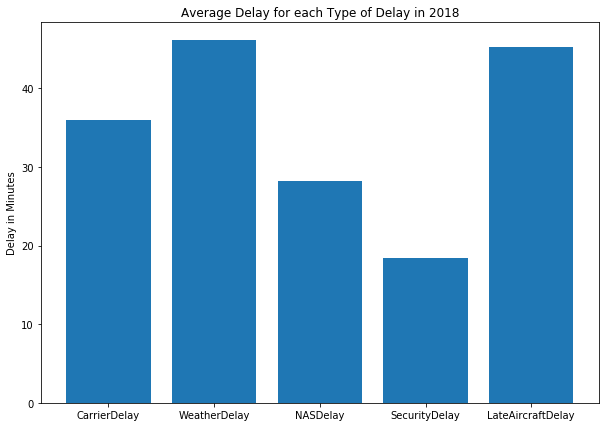

In [68]:
import matplotlib.pyplot as plt
x = delayslist
y = avgdelays
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x, y)
plt.xticks(x, x)
plt.ylabel("Delay in Minutes")
plt.title("Average Delay for each Type of Delay in 2018")
plt.show()


## Feature Engineering

##### Classifier of delay columnns

In [69]:
#adding delayed column for over delays over 60min
df08_onehot_test['delayedOverHour'] = 0
df08_onehot_test.loc[df08['ArrDelay'] > 60,'delayedOverHour'] = 1

In [70]:
#adding delayed column for over delays over 30min
df08_onehot_test['delayedOver30'] = 0
df08_onehot_test.loc[df08['ArrDelay'] > 30,'delayedOver30'] = 1

In [71]:
df08_onehot_test.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Airline_NW,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,delayedOverHour,delayedOver30
3163108,2008,6,27,5,1953,2000,2100,2105,5778,67,...,0,1,0,0,0,0,0,0,0,0
4161727,2008,7,27,7,1042,1036,1112,1100,65,30,...,0,0,0,0,0,0,0,0,0,0
1603857,2008,3,27,4,1449,1454,1945,1957,118,176,...,1,0,0,0,0,0,0,0,0,0
565337,2008,1,1,2,2150,2115,2307,2251,1427,197,...,0,0,0,0,0,0,0,0,0,0
4612539,2008,8,29,5,1514,1513,1647,1702,238,93,...,0,0,0,0,0,0,0,0,0,0


##### Type of Delay to binary

In [72]:
df08_test = df08_onehot_test

In [73]:
#transforming delays to True or false rather than the time from each delay
df08_test.loc[df08["CarrierDelay"] > 0,'CarrierDelay'] = 1
df08_test.loc[df08["CarrierDelay"] <= 0,'CarrierDelay'] = 0
df08_test.loc[df08["WeatherDelay"] > 0,'WeatherDelay'] = 1
df08_test.loc[df08["WeatherDelay"] <= 0,'WeatherDelay'] = 0
df08_test.loc[df08["NASDelay"] > 0,'NASDelay'] = 1
df08_test.loc[df08["NASDelay"] <= 0,'WeatherDelay'] = 0
df08_test.loc[df08["SecurityDelay"] > 0,'SecurityDelay'] = 1
df08_test.loc[df08["SecurityDelay"] <= 0,'SecurityDelay'] = 0
df08_test.loc[df08["LateAircraftDelay"] > 0,'LateAircraftDelay'] = 1
df08_test.loc[df08["LateAircraftDelay"] <= 0,'LateAircraftDelay'] = 0

In [74]:
df08_test.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Airline_NW,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,delayedOverHour,delayedOver30
3163108,2008,6,27,5,1953,2000,2100,2105,5778,67,...,0,1,0,0,0,0,0,0,0,0
4161727,2008,7,27,7,1042,1036,1112,1100,65,30,...,0,0,0,0,0,0,0,0,0,0
1603857,2008,3,27,4,1449,1454,1945,1957,118,176,...,1,0,0,0,0,0,0,0,0,0
565337,2008,1,1,2,2150,2115,2307,2251,1427,197,...,0,0,0,0,0,0,0,0,0,0
4612539,2008,8,29,5,1514,1513,1647,1702,238,93,...,0,0,0,0,0,0,0,0,0,0


## Predicting whether you will be delayed
average layover is an hour

In [75]:
feature_cols = list(df08_test.columns)
#feature_cols

In [76]:
feature_cols

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'FlightNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 '_ABE',
 '_ABI',
 '_ABQ',
 '_ABY',
 '_ACK',
 '_ACT',
 '_ACV',
 '_ACY',
 '_ADK',
 '_ADQ',
 '_AEX',
 '_AGS',
 '_AKN',
 '_ALB',
 '_ALO',
 '_AMA',
 '_ANC',
 '_ASE',
 '_ATL',
 '_ATW',
 '_AUS',
 '_AVL',
 '_AVP',
 '_AZO',
 '_BDL',
 '_BET',
 '_BFL',
 '_BGM',
 '_BGR',
 '_BHM',
 '_BIL',
 '_BIS',
 '_BJI',
 '_BLI',
 '_BMI',
 '_BNA',
 '_BOI',
 '_BOS',
 '_BPT',
 '_BQK',
 '_BQN',
 '_BRO',
 '_BRW',
 '_BTM',
 '_BTR',
 '_BTV',
 '_BUF',
 '_BUR',
 '_BWI',
 '_BZN',
 '_CAE',
 '_CAK',
 '_CDC',
 '_CDV',
 '_CEC',
 '_CHA',
 '_CHO',
 '_CHS',
 '_CIC',
 '_CID',
 '_CLD',
 '_CLE',
 '_CLL',
 '_CLT',
 '_CMH',
 '_CMI',
 '_CMX',
 '_COD',
 '_COS',
 '_CPR',
 '_CRP',
 '_CRW',
 '_CSG',
 '_CVG',
 '_CWA',
 '_DAB'

In [77]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [78]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay",'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay", "DepTime","TaxiIn","TaxiOut"]
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.delayedOverHour # Target variable

In [79]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 331) (1096806,)
(274202, 331) (274202,)


###### Decision Tree

In [80]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [81]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8993989832313404


###### Random Forest
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [82]:
X = df08_test[feature_cols] # Features
y = df08_test.delayedOverHour # Target variable

In [84]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 331) (1096806,)
(274202, 331) (274202,)


In [85]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.92860373009679


In [86]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DayofMonth           Importance: 0.23
Variable: DayOfWeek            Importance: 0.12
Variable: Month                Importance: 0.11
Variable: CRSDepTime           Importance: 0.09
Variable: CRSArrTime           Importance: 0.09
Variable: FlightNum            Importance: 0.07
Variable: CRSElapsedTime       Importance: 0.07
Variable: Distance             Importance: 0.03
Variable: _EWR                 Importance: 0.01
Variable: _ORD                 Importance: 0.01
Variable: Year                 Importance: 0.0
Variable: _ABE                 Importance: 0.0
Variable: _ABI                 Importance: 0.0
Variable: _ABQ                 Importance: 0.0
Variable: _ABY                 Importance: 0.0
Variable: _ACK                 Importance: 0.0
Variable: _ACT                 Importance: 0.0
Variable: _ACV                 Importance: 0.0
Variable: _ACY                 Importance: 0.0
Variable: _ADK                 Importance: 0.0
Variable: _ADQ                 Importance: 0.0
Var

In [ ]:
# #Having trouble graphing a tree with all the one-hot encoded cat-features

# # Extract single tree
# estimator = model.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='delays.dot', 
#                 feature_names = feature_cols,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'delays.dot', '-o', 'delay.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'delay.png')

###### Cross Validation with KFolds of RF

In [87]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt

X.to_numpy() # create an array
# Create another array
kf = KFold(n_splits=10) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=10, random_state=None, shuffle=False)


In [88]:
import time

losses = []
models = []
test_scores = []
train_scores = []
numfold = []
num=0
s_time = time.time()

for k in range(2): #make bigger than 2 to make larger ensemble
    #preventing overfitting with Kfold
    kfold = KFold(10, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print("-----------")
        tr_x,tr_y = X.iloc[tr_inds],y.iloc[tr_inds]
        val_x,val_y = X.iloc[val_inds],y.iloc[val_inds]
        rf = RandomForestClassifier(n_estimators = 5, random_state = 42)
        model = rf.fit(tr_x,tr_y)
        predictions = rf.predict(X_test)
        models.append(model)
        test_scores.append(model.score(X_test, y_test))
        train_scores.append(model.score(X_train, y_train))
        num+=1
        numfold.append(num)
        print("the %d fold score is %f"%((k_fold+1),model.score(X_test, y_test)))

-----------
-----------
the 1 fold score is 0.972648
-----------
-----------
the 2 fold score is 0.973410
-----------
-----------
the 3 fold score is 0.973206
-----------
-----------
the 4 fold score is 0.973417
-----------
-----------
the 5 fold score is 0.973323
-----------
-----------
the 1 fold score is 0.972768
-----------
-----------
the 2 fold score is 0.972994
-----------
-----------
the 3 fold score is 0.972495
-----------
-----------
the 4 fold score is 0.972786
-----------
-----------
the 5 fold score is 0.973195


In [ ]:
# #doesn't work currently

# te_scores = []
# tr_scores = []
# nfold = []
# n=0

# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index] #Problem with indexing for KFolds
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     rf = RandomForestClassifier(n_estimators = 5, random_state = 42)
#     model = rf.fit(X_train, y_train)
#     predictions = rf.predict(X_test)
#     te_scores.append(model.score(X_test, y_test))
#     tr_scores.append(model.score(X_train, y_train))
#     print("Fold %d Score:", numfold,model.score(X_test, y_test))
#     n+=1
#     nfold.append(n)

# print(te_scores)
# print(tr_scores)

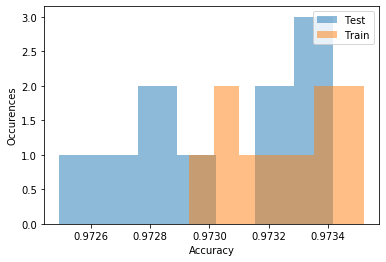

In [91]:
from matplotlib import pyplot

x = test_scores
y = train_scores

bins = 7

pyplot.hist(x, bins, alpha=0.5, label='Test')
pyplot.hist(y, bins, alpha=0.5, label='Train')
pyplot.legend(loc='upper right')
pyplot.ylabel("Occurences")
pyplot.xlabel("Accuracy")
pyplot.show()

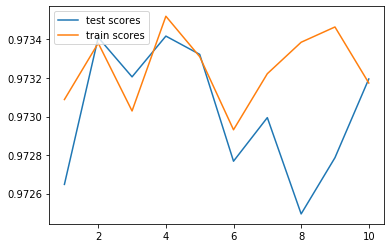

In [90]:
plt.plot(numfold, test_scores)
plt.plot(numfold, train_scores)

plt.legend(['test scores', 'train scores'], loc='upper left')

plt.show()

In [ ]:
# #output of decision tree
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('airlinedelays.png')
# Image(graph.create_png())

## Predicting Amount of Time Delayed

In [115]:
feature_cols = list(df08_test.columns)
#feature_cols

In [116]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [117]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay","DepTime","TaxiIn","TaxiOut"]
#'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay", 
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.ArrDelay # Target variable

In [118]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 336) (1096806,)
(274202, 336) (274202,)


In [119]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.43041202768938147


In [120]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NASDelay             Importance: 0.24
Variable: LateAircraftDelay    Importance: 0.13
Variable: CarrierDelay         Importance: 0.09
Variable: DayofMonth           Importance: 0.07
Variable: CRSArrTime           Importance: 0.05
Variable: FlightNum            Importance: 0.05
Variable: Month                Importance: 0.04
Variable: DayOfWeek            Importance: 0.04
Variable: CRSDepTime           Importance: 0.04
Variable: CRSElapsedTime       Importance: 0.04
Variable: Distance             Importance: 0.02
Variable: WeatherDelay         Importance: 0.01
Variable: _ORD                 Importance: 0.01
Variable: Year                 Importance: 0.0
Variable: SecurityDelay        Importance: 0.0
Variable: _ABE                 Importance: 0.0
Variable: _ABI                 Importance: 0.0
Variable: _ABQ                 Importance: 0.0
Variable: _ABY                 Importance: 0.0
Variable: _ACK                 Importance: 0.0
Variable: _ACT                 Importance: 0.0


In [121]:
feature_cols = list(df08_test.columns)
#feature_cols

In [122]:
categorical_feature_mask = df08_test.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df08_test.columns[categorical_feature_mask].tolist()
#list(categorical_feature_mask)

In [123]:
foresight_cols = ["ArrTime","ActualElapsedTime","DepDelay",'delayedOver30', 'delayedOverHour',"AirTime","ArrDelay","TaxiIn","TaxiOut"]
#'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay',"CarrierDelay", "DepTime",
cols_drop = foresight_cols
for i in cols_drop:
    feature_cols.remove(i)
X = df08_test[feature_cols] # Features
y = df08_test.ArrDelay # Target variable

In [124]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1096806, 337) (1096806,)
(274202, 337) (274202,)


In [125]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
model = rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Score:", model.score(X_test, y_test))

Score: 0.8949579723215618


In [126]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: CRSDepTime           Importance: 0.26
Variable: NASDelay             Importance: 0.24
Variable: DepTime              Importance: 0.21
Variable: LateAircraftDelay    Importance: 0.12
Variable: CarrierDelay         Importance: 0.08
Variable: CRSArrTime           Importance: 0.02
Variable: Month                Importance: 0.01
Variable: DayofMonth           Importance: 0.01
Variable: DayOfWeek            Importance: 0.01
Variable: FlightNum            Importance: 0.01
Variable: CRSElapsedTime       Importance: 0.01
Variable: Distance             Importance: 0.01
Variable: Year                 Importance: 0.0
Variable: WeatherDelay         Importance: 0.0
Variable: SecurityDelay        Importance: 0.0
Variable: _ABE                 Importance: 0.0
Variable: _ABI                 Importance: 0.0
Variable: _ABQ                 Importance: 0.0
Variable: _ABY                 Importance: 0.0
Variable: _ACK                 Importance: 0.0
Variable: _ACT                 Importance: 0.0
V